# Bias correct the forecast data
### Time taken: < 1 min (cluster only needed for anomalising sst below)

Note that the CAFE-f5 dataset is used here to calculate the biases so that the biases can be estimated using a relatively long time period (31 years: 1980-2020). The CAFE-f6 model dataset is initialised over a shorter period (2005-2020), so provides, for example, only 7 years of data at 115 months lead (2014-2020) that could be compared to observations to estimate biases.

Note only the drought index requires bias correction in order to pass the fidelity testing (see `3_fidelity_testing.ipynb`). Here, the mean model biases are estimated as the average difference between the AWAP and CAFE-f5 1990-2020 climatological averages for each lead. Raw model values of Dec FFDI are used for subsequent analysis.

In [1]:
import numpy as np

import myfuncs as my

from dask.distributed import Client
from dask_jobqueue import PBSCluster

import warnings
warnings.filterwarnings("ignore")

In [2]:
walltime = '02:00:00'
cores = 48
memory = '192GB'
cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),
                                '-l mem='+str(memory),
                                '-P xv83',
                                '-l jobfs=100GB',
                                '-l storage=gdata/xv83+gdata/v14+scratch/v14'],
                     local_directory='$PBS_JOBFS',
                     # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
                     header_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: http://10.6.62.47:8787/status,
Dashboard: http://10.6.62.47:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.62.47:33243,Workers: 0
Dashboard: http://10.6.62.47:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


--------
# Parameters

In [3]:
period = slice('1990-01-01','2020-12-31')
SOND = [9,10,11,12]

clobber = False # If False, read intermediate datasets from disk if they exist

--------
# Estimate the model biases for the drought index from CAFE-f5

In [4]:
def lead_days_to_months(fcst, days_to_zero_lead=60):
    """ Hack to convert lead_time in days to months """
    forecast_month = np.unique(fcst.time.dt.month)
    assert len(forecast_month) == 1
    forecast_month = forecast_month[0]

    lead_year = np.floor(((fcst.lead_time - days_to_zero_lead) / 365))
    lead_month = lead_year * 12 + forecast_month - fcst.init_date.dt.month
    return fcst.assign_coords({'lead_time': lead_month})

In [5]:
awap_precip_ann_reg = my.open_zarr(
    'data/AWAP_precip-annDEC-accl_region.zarr',
    open_zarr_kwargs={'use_cftime':True})
awap_precip_ann_reg_period = awap_precip_ann_reg.sel(time=period)

f5_precip_ann_reg = my.open_zarr('data/CAFE-f5_precip-annDEC-accl_region.zarr')
f5_precip_ann_reg = lead_days_to_months(f5_precip_ann_reg)
f5_precip_ann_reg_period = f5_precip_ann_reg.sel(time=period)

In [6]:
bias_precip_ann_reg = my.get_bias(
    f5_precip_ann_reg_period.mean('ensemble'), 
    awap_precip_ann_reg_period)

## Figure for reviewer: delete me

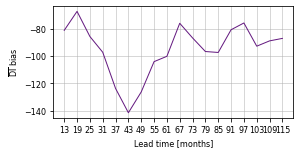

In [36]:
import matplotlib.pyplot as plt
from matplotlib import cm

ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize}

with plt.rc_context(rc_context):
    fig = plt.figure(constrained_layout=True, figsize=(4,2.0))

    col = cm.get_cmap('magma')(0.3)

    ax = fig.add_subplot(111)
    ax.grid(zorder=-1, linewidth=0.5)
    to_plot = bias_precip_ann_reg['precip_ann'].sum('month')
    ax.plot(to_plot.lead_time, to_plot, 
            linestyle='-', color=col, linewidth=1)

    ax.set_ylabel(r'$\overline{\mathrm{DI}}$ bias');
    ax.set_xticks(to_plot.lead_time.values)
    ax.set_xlabel('Lead time [months]');

fig.savefig(f'./figures/DI_bias.pdf', format='pdf',
            bbox_inches='tight')

### Remove the bias from CAFE-f5

In [6]:
f5_precip_ann_reg_bc = my.remove_bias(f5_precip_ann_reg, bias_precip_ann_reg)
f5_precip_ann_reg_bc = f5_precip_ann_reg_bc.chunk(
    {d: -1 for d in f5_precip_ann_reg_bc.dims})
f5_precip_ann_reg_bc = my.to_zarr(
    f5_precip_ann_reg_bc, 'data/CAFE-f5_precip-annDEC-accl_region_bc.zarr', clobber=clobber)

### Remove the bias from CAFE-f6

In [7]:
f6_precip_ann_reg = my.open_zarr('data/CAFE-f6_precip-annDEC-accl_region.zarr')
f6_precip_ann_reg = lead_days_to_months(f6_precip_ann_reg)

In [8]:
f6_precip_ann_reg_bc = my.remove_bias(f6_precip_ann_reg, bias_precip_ann_reg)
f6_precip_ann_reg_bc = f6_precip_ann_reg_bc.chunk(
    {d: -1 for d in f6_precip_ann_reg_bc.dims})
f6_precip_ann_reg_bc = my.to_zarr(
    f6_precip_ann_reg_bc, 'data/CAFE-f6_precip-annDEC-accl_region_bc.zarr', clobber=clobber)

### Sanity check that bias correction is doing what it's supposed to
Model climatologies of the bias corrected f5 data over `period` should match the observations at all lead times

In [9]:
f5_precip_ann_reg_period_bc = my.remove_bias(f5_precip_ann_reg_period, bias_precip_ann_reg)

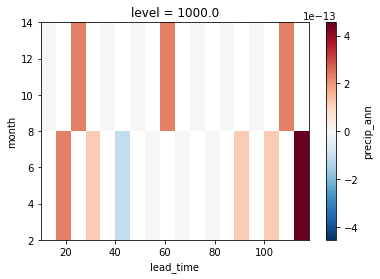

In [10]:
test = my.reindex_forecast(f5_precip_ann_reg_period_bc['precip_ann'])
fcst_clim = test.mean('ensemble').groupby('init_date.month').mean('init_date')
obsv_clim = awap_precip_ann_reg_period['precip_ann'].mean('time')
(fcst_clim - obsv_clim).plot()

--------
# Remove the CAFE-f5 model climatology from the driver indices to generate anomalies

### SON sea surface temperate

In [12]:
f6_sst = my.open_zarr('data/CAFE-f6_sst-SON-full.zarr')
f5_sst = my.open_zarr('data/CAFE-f5_sst-SON-full.zarr')

f5_sst_period = f5_sst.sel(time=period)
f5_sst_clim = my.forecast_clim(f5_sst_period.mean('ensemble'))

In [13]:
f5_sst_anom = my.remove_bias(f5_sst, f5_sst_clim)
f5_sst_anom = my.to_zarr(
    f5_sst_anom, 'data/CAFE-f5_sst-SON.zarr', clobber=clobber)

In [14]:
f6_sst_anom = my.remove_bias(f6_sst, f5_sst_clim)
f6_sst_anom = my.to_zarr(
    f6_sst_anom, 'data/CAFE-f6_sst-SON.zarr', clobber=clobber)

### SOND 500 hPa geopotential height

In [15]:
f6_h500 = my.open_zarr('data/CAFE-f6_h500-SOND-full.zarr')
f5_h500 = my.open_zarr('data/CAFE-f5_h500-SOND-full.zarr')

f5_h500_period = f5_h500.sel(time=period)
f5_h500_clim = my.forecast_clim(f5_h500_period.mean('ensemble'))

In [16]:
f5_h500_anom = my.remove_bias(f5_h500, f5_h500_clim)
f5_h500_anom = my.to_zarr(
    f5_h500_anom, 'data/CAFE-f5_h500-SOND.zarr', clobber=clobber)

In [17]:
f6_h500_anom = my.remove_bias(f6_h500, f5_h500_clim)
f6_h500_anom = my.to_zarr(
    f6_h500_anom, 'data/CAFE-f6_h500-SOND.zarr', clobber=clobber)

### NINO 3.4

In [18]:
f6_nino34 = my.open_zarr('data/CAFE-f6_Nino34-SOND-full.zarr')
f5_nino34 = my.open_zarr('data/CAFE-f5_Nino34-SOND-full.zarr')

f5_nino34_period = f5_nino34.sel(time=period)
f5_nino34_clim = my.forecast_clim(f5_nino34_period.mean('ensemble'))

In [19]:
f5_nino34_anom = my.remove_bias(f5_nino34, f5_nino34_clim)
f5_nino34_anom = my.to_zarr(
    f5_nino34_anom, 'data/CAFE-f5_Nino34-SOND.zarr', clobber=clobber)

In [20]:
f6_nino34_anom = my.remove_bias(f6_nino34, f5_nino34_clim)
f6_nino34_anom = my.to_zarr(
    f6_nino34_anom, 'data/CAFE-f6_Nino34-SOND.zarr', clobber=clobber)

### DMI

In [22]:
f6_dmi = my.open_zarr('data/CAFE-f6_DMI-SON-full.zarr')
f5_dmi = my.open_zarr('data/CAFE-f5_DMI-SON-full.zarr')

f5_dmi_period = f5_dmi.sel(time=period)
f5_dmi_clim = my.forecast_clim(f5_dmi_period.mean('ensemble'))

In [23]:
f5_dmi_anom = my.remove_bias(f5_dmi, f5_dmi_clim)
f5_dmi_anom = my.to_zarr(
    f5_dmi_anom, 'data/CAFE-f5_DMI-SON.zarr', clobber=clobber)

In [24]:
f6_dmi_anom = my.remove_bias(f6_dmi, f5_dmi_clim)
f6_dmi_anom = my.to_zarr(
    f6_dmi_anom, 'data/CAFE-f6_DMI-SON.zarr', clobber=clobber)

### SAM

In [26]:
f5_slp = my.open_zarr('data/CAFE-f5_slp.zarr')['slp']
f6_slp = my.open_zarr('data/CAFE-f6_slp.zarr')['slp']

In [27]:
f5_slp_stacked = my.reindex_forecast(f5_slp)
f5_sam_stacked = my.calc_sam(
    f5_slp_stacked,
    period,
    groupby_dim='init_date').rename('sam')
f5_sam = my.reindex_forecast(f5_sam_stacked)

f5_sam_SOND = my.resample_months_in_year(
    f5_sam, SOND, method='mean').rename('sam_SOND')
f5_sam_SOND = my.to_zarr(
    f5_sam_SOND, 'data/CAFE-f5_SAM-SOND.zarr', clobber=clobber)

In [28]:
f6_slp_stacked = my.reindex_forecast(f6_slp)
f6_sam_stacked = my.calc_sam(
    f6_slp_stacked, 
    period, 
    slp_for_clim=f5_slp_stacked, 
    groupby_dim='init_date').rename('sam')
f6_sam = my.reindex_forecast(f6_sam_stacked)

f6_sam_SOND = my.resample_months_in_year(
    f6_sam, SOND, method='mean').rename('sam_SOND')
f6_sam_SOND = my.to_zarr(
    f6_sam_SOND, 'data/CAFE-f6_SAM-SOND.zarr', clobber=clobber)

--------
# End notebook

In [31]:
cluster.close()
client.close()